In [35]:
import pandas as pd
import itertools
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [36]:
save_images = False
file = "results.csv"
sep = ","
enc = "utf-8"

df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [37]:
gt_df = pd.read_csv("number_gtos.csv", sep=" ", encoding=enc)
gt_df.columns = ["id", "|Omega|"]

In [38]:
"""
cp->parameter.flow_steps  = 2;
cp->parameter.weight_decay = weight_decay;
cp->parameter.kmeans_ite  = 5;
cp->parameter.kmeans_resampling = 2;
cp->parameter.max_ite_main = 5;
//cp->parameter.max_ite_main = 1;
cp->parameter.backward_step = true;
cp->parameter.stopping_ratio = 0.05;
"""

knns = [30, 60]
reg_strengths = [0.0001, 0.01]

cp_args = list(itertools.product(*[reg_strengths, knns]))
n_cp_args = len(cp_args)

stat_cols = [
        "|V|", # nr of vertices
        "|T|", # nr of triangles
        "|S_M|", # nr of superpoints in the mesh partition
        "|E_M|", # nr of superedges in the mesh superpoint graph
        "OOA_M", # overall object accuracy of the mesh
        "|S_M_k|", # nr of superpoints in the mesh partition
        "|E_M_k|", # nr of superedges in the mesh superpoint graph
        "OOA_M_k", # overall object accuracy of the mesh
        "|S_M_ks|", # nr of superpoints in the mesh partition
        "|E_M_ks|", # nr of superedges in the mesh superpoint graph
        "OOA_M_ks", # overall object accuracy of the mesh
        "|S_P|", # nr of superpoints in the point cloud partition
        "|E_P|", # nr of superedges in the point cloud superpoint graph
        "OOA_P", # overall object accuracy of the point cloud
        "mean(n)", # average number of neighbours per vertex
        "std(n)", # std of neighbours per vertex
        "median(n)", # median of neighbours per vertex
        "|Omega|", # number of ground truth objects
        ]

ite_vars = ["s1", # saturation in cp-iteration 1 
    "s2", "s3", "s4", "s5",
    "e1_1", # first error term in cp-iteration 1
    "e1_2", "e1_3", "e1_4", "e1_5",
    "e2_1", # second error term in cp-iteration 1
    "e2_2", "e2_3", "e2_4", "e2_5",
    "n_ite", "exit_code" # number of iterations & exit code
   ]

for post in ["_M", "_M_k", "_M_ks", "_P"]:
    for ite_var in ite_vars:
        stat_cols.append(ite_var + post)

# add ratio column
def get_ratio(stat_df, col_sp, col_ooa):
    l1 = stat_df.loc[:, col_sp] / (stat_df.loc[:, "|Omega|"])
    l2 = stat_df.loc[:, "|Omega|"] / (stat_df.loc[:, col_sp])
    L = pd.concat((l1, l2), axis=1).max(axis=1)
    r = stat_df.loc[:, col_ooa] / L
    return r

stats_list = n_cp_args * [None]

min_n_samples = 10e6
del_idxs = []
for i in range(n_cp_args):
    reg_strength, knn = cp_args[i]
    tmp_df = df[(df["lambda"] == reg_strength) & (df["knn"] == knn)]
    print("Combination ({0}, {1}) with shape {2}".format(reg_strength, knn, tmp_df.shape))
    if tmp_df.shape[0] == 0:
        del_idxs.append(i)
        continue
    print(tmp_df["id"].tolist())
    
    tmp_df = pd.merge(tmp_df, gt_df, how ="inner", on =["id"])
    
    stat_df = tmp_df.loc[:, stat_cols]
    n_rows = stat_df.shape[0]
    if n_rows < min_n_samples:
        min_n_samples = n_rows
min_n_samples -= 1
print("nr samples: {0}".format(min_n_samples))

if len(del_idxs) > 0:
    for i in reversed(del_idxs):
        del cp_args[i]
n_cp_args = len(cp_args)

for i in range(n_cp_args):
    reg_strength, knn = cp_args[i]
    tmp_df = df[(df["lambda"] == reg_strength) & (df["knn"] == knn)]
    
    tmp_df = pd.merge(tmp_df, gt_df, how ="inner", on =["id"])
    
    stat_df = tmp_df.loc[:min_n_samples, stat_cols]
    
    ratio_M = get_ratio(stat_df=stat_df, col_sp="|S_M|", col_ooa="OOA_M")
    ratio_M_k = get_ratio(stat_df=stat_df, col_sp="|S_M_k|", col_ooa="OOA_M_k")  
    ratio_M_ks = get_ratio(stat_df=stat_df, col_sp="|S_M_ks|", col_ooa="OOA_M_ks")  
    ratio_P = get_ratio(stat_df=stat_df, col_sp="|S_P|", col_ooa="OOA_P")    
    
    rf = pd.DataFrame(data=[ratio_M, ratio_P, ratio_M_k, ratio_M_ks]).transpose()
    rf.columns = ["r_M", "r_P", "r_M_k", "r_M_ks"]
    
    stat_df_ = pd.concat([stat_df, rf], axis=1)
    
    mean_stat = stat_df_.mean(axis=0)
    std_stat = stat_df_.std(axis=0)
    median_stat = stat_df_.median(axis=0)
    
    stats = pd.concat([mean_stat, std_stat, median_stat], axis=1).transpose()
    #index_str = "_{0:.3f}_{1}".format(reg_strength, knn)
    #stats.index = ["mean" + index_str, "std" + index_str, "median" + index_str]
    stats.index = ["mean", "std", "median"]
    stats_t = ((reg_strength, knn), stats, stat_df_)
    stats_list[i] = stats_t

Combination (0.0001, 30) with shape (81, 96)
[510, 618, 1455, 1507, 1240, 515, 687, 1282, 400, 1390, 932, 1439, 550, 1296, 593, 373, 111, 1418, 782, 731, 1329, 1453, 759, 1065, 413, 288, 1265, 1352, 718, 886, 1387, 483, 1249, 428, 547, 964, 463, 1297, 1420, 1412, 325, 1095, 182, 293, 1456, 385, 1260, 1151, 969, 926, 1322, 1174, 1434, 482, 386, 1053, 1057, 1305, 215, 549, 857, 794, 961, 207, 132, 1323, 1015, 1241, 887, 68, 297, 580, 1041, 787, 353, 1435, 1359, 1345, 1298, 626, 715]
Combination (0.0001, 60) with shape (81, 96)
[510, 618, 1455, 1507, 1240, 515, 687, 1282, 400, 1390, 932, 1439, 550, 1296, 593, 373, 111, 1418, 782, 731, 1329, 1453, 759, 1065, 413, 288, 1265, 1352, 718, 886, 1387, 483, 1249, 428, 547, 964, 463, 1297, 1420, 1412, 325, 1095, 182, 293, 1456, 385, 1260, 1151, 969, 926, 1322, 1174, 1434, 482, 386, 1053, 1057, 1305, 215, 549, 857, 794, 961, 207, 132, 1323, 1015, 1241, 887, 68, 297, 580, 1041, 787, 353, 1435, 1359, 1345, 1298, 626, 715]
Combination (0.01, 30) with 

In [39]:
n = min_n_samples + 1
for i in range(n_cp_args):
    reg_strength, knn = cp_args[i]
    print(r"$\lambda={0}, k={1}$".format(reg_strength, knn))
    csum = np.sum(stats_list[i][-1]["|S_M|"] > stats_list[i][-1]["|S_P|"])
    print(r"$|S_M| > |S_P|$: {0}".format(csum==n))
    csum = np.sum(stats_list[i][-1]["|S_P|"] < stats_list[i][-1]["|S_M_k|"])
    print(r"$|S_P| < |S_M_k|$: {0}".format(csum==n))
    csum = np.sum(stats_list[i][-1]["|S_M|"] < stats_list[i][-1]["|S_M_k|"])
    print(r"$|S_M| < |S_M_k|$: {0}".format(csum==n))
    
    csum = np.sum(stats_list[0][-1]["OOA_M"] > stats_list[0][-1]["OOA_P"])
    print(r"$OOA_M > OOA_P$: {0}".format(csum==n))
    csum = np.sum(stats_list[0][-1]["OOA_P"] < stats_list[0][-1]["OOA_M_k"])
    print(r"$OOA_P < OOA_M_k$: {0}".format(csum==n))
    csum = np.sum(stats_list[0][-1]["OOA_M"] < stats_list[0][-1]["OOA_M_k"])
    print(r"$OOA_M < OOA_M_k$: {0}".format(csum==n))

#print(stats_list[0][-1].loc[:, ["|S_M|", "|S_P|"]])
#print(np.sum(stats_list[0][-1]["|S_M|"] < stats_list[0][-1]["|S_P|"]))
#print(np.sum(stats_list[0][-1]["|S_P|"] < stats_list[0][-1]["|S_M_k|"]))
#print(np.sum(stats_list[0][-1]["|S_M|"] < stats_list[0][-1]["|S_M_k|"]))
#print(np.sum(stats_list[0][-1]["OOA_M"] > stats_list[0][-1]["OOA_P"]))
#print(np.sum(stats_list[0][-1]["OOA_P"] < stats_list[0][-1]["OOA_M_k"]))
#print(np.sum(stats_list[0][-1]["OOA_M"] < stats_list[0][-1]["OOA_M_k"]))

$\lambda=0.0001, k=30$
$|S_M| > |S_P|$: False
$|S_P| < |S_M_k|$: True
$|S_M| < |S_M_k|$: True
$OOA_M > OOA_P$: False
$OOA_P < OOA_M_k$: True
$OOA_M < OOA_M_k$: False
$\lambda=0.0001, k=60$
$|S_M| > |S_P|$: False
$|S_P| < |S_M_k|$: True
$|S_M| < |S_M_k|$: True
$OOA_M > OOA_P$: False
$OOA_P < OOA_M_k$: True
$OOA_M < OOA_M_k$: False
$\lambda=0.01, k=30$
$|S_M| > |S_P|$: False
$|S_P| < |S_M_k|$: True
$|S_M| < |S_M_k|$: True
$OOA_M > OOA_P$: False
$OOA_P < OOA_M_k$: True
$OOA_M < OOA_M_k$: False
$\lambda=0.01, k=60$
$|S_M| > |S_P|$: False
$|S_P| < |S_M_k|$: True
$|S_M| < |S_M_k|$: True
$OOA_M > OOA_P$: False
$OOA_P < OOA_M_k$: True
$OOA_M < OOA_M_k$: False


In [40]:
x = np.arange(n_cp_args, dtype=np.uint32)

In [41]:
def plot(x, y, ylabel, labels, xticks, title, miny=None, maxy=None):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(8)
    plt.rc("font", size=20)
    
    ax = f.add_axes([0,0,1,1])
    if miny is not None and maxy is not None:
        ax.set(ylim=[miny, maxy])
    width = 0.225    
    d_ = np.array(x, copy=True)
    d_ = d_.astype(np.float32)
    
    for i in range(y.shape[1]):
        #plt.plot(x, y[:, i], "x", label=labels[i])
        #print(y[:, i])
        ax.bar(x=d_, height=y[:, i], width=width)
        d_ += width
    #plt.legend()
    ax.legend(labels=labels)
    plt.xticks(x, xticks, rotation="vertical")
    plt.title(title)
    plt.ylabel(ylabel)
    #plt.show()

In [42]:
def plot_df(cp_args, n_cp_args, stats_list, ex_cols, col_names, title=None, use_log=False, describe=False, print_latex=False, val_multiplier=1, ylabel=None, xlabel=None):
    df_all = None
    for i in range(n_cp_args):
        ex_cols_ = ex_cols.copy()
        col_names_ = col_names.copy()
        if i == 1 or i == 3 or i == 5:
            del ex_cols_[2]
            del col_names_[2]
        df = stats_list[i][2].loc[:, ex_cols_].copy()
        if use_log:
            df = np.log10(df)
        col = []
        for c in col_names_:
            col.append(c + r"$({0}, {1})$".format(cp_args[i][0], cp_args[i][1]))
        df.columns = col
        #print(col[-1], df)
        if df_all is None:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], axis=0)
    #print(df_all)
    if describe:
        print(df_all.describe(include="all"))
    if print_latex:
        df_desc = df_all.describe(include="all")
        #print(df_desc)
        df_desc = df_desc.loc[["mean", "std", "25%", "50%", "75%"]]
        df_desc = df_desc * val_multiplier
        latex_str = df_desc.to_latex(escape=False, float_format="%.2f")
        print(latex_str)
    df_all.plot(kind="box", figsize=(12,8), rot=90, title=title, grid=True, showmeans=True, ylabel=ylabel, xlabel=xlabel)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  $g$:$(0.0001, 30)$ &  $e$:$(0.0001, 30)$ &  $M$:$(0.0001, 30)$ &  $g$:$(0.0001, 60)$ &  $e$:$(0.0001, 60)$ &  $g$:$(0.01, 30)$ &  $e$:$(0.01, 30)$ &  $M$:$(0.01, 30)$ &  $g$:$(0.01, 60)$ &  $e$:$(0.01, 60)$ \\
\midrule
mean &               20.91 &               23.25 &                4.80 &               37.84 &               42.97 &             96.14 &            107.04 &              7.39 &            345.75 &            407.31 \\
std  &                8.91 &                9.63 &                2.42 &               15.52 &               16.01 &             38.52 &             42.56 &              3.71 &            134.93 &            144.56 \\
25%  &               15.29 &               17.15 &                3.23 &               28.15 &               32.95 &             73.00 &             80.06 &              4.65 &            264.79 &            311.77 \\
50%  &               18.11 &               20.61 &                3.95 &           

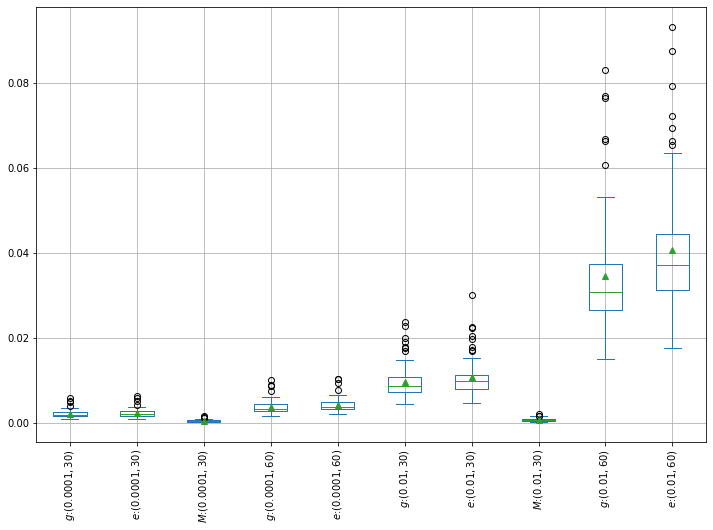

In [43]:
#plot(x=x, y=ratios, ylabel=r"$r$", labels=[r"$r_g$", r"$r_e$", r"$r_M$", r"$r_{M^\prime}$"], xticks=params_list, title=r"ratio $r$")

plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:"],
       ex_cols=["r_M", "r_P", "r_M_k"], print_latex=True, val_multiplier=10e3)
if save_images:
    plt.savefig("ratio.png", bbox_inches="tight")

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  $g$:$(0.0001, 30)$ &  $e$:$(0.0001, 30)$ &  $M$:$(0.0001, 30)$ &  $g$:$(0.0001, 60)$ &  $e$:$(0.0001, 60)$ &  $g$:$(0.01, 30)$ &  $e$:$(0.01, 30)$ &  $M$:$(0.01, 30)$ &  $g$:$(0.01, 60)$ &  $e$:$(0.01, 60)$ \\
\midrule
mean &                0.93 &                0.92 &                0.98 &                0.92 &                0.90 &              0.92 &              0.91 &              0.98 &              0.89 &              0.87 \\
std  &                0.03 &                0.03 &                0.02 &                0.04 &                0.04 &              0.03 &              0.04 &              0.02 &              0.04 &              0.05 \\
25%  &                0.91 &                0.91 &                0.98 &                0.90 &                0.88 &              0.90 &              0.89 &              0.97 &              0.86 &              0.85 \\
50%  &                0.93 &                0.92 &                0.99 &           

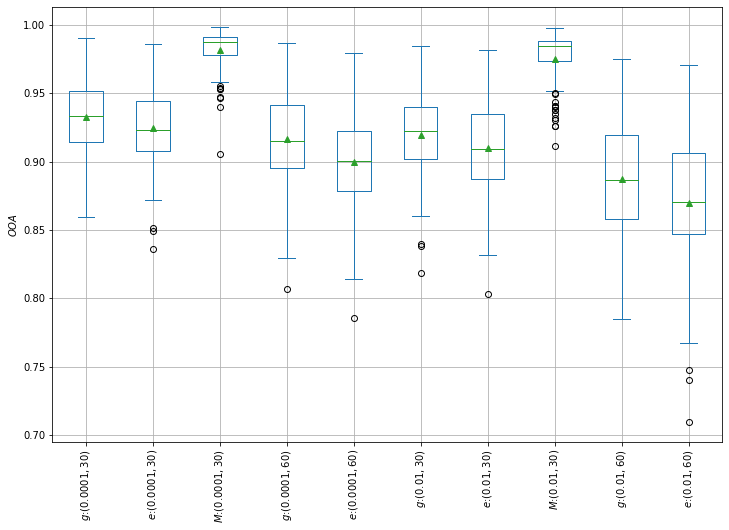

In [44]:
#plot(x=x, y=ooas, ylabel=r"$OOA$", labels=[r"$OOA_g$", r"$OOA_e$", r"$OOA_{M}$", r"$OOA_{M^\prime}$"],
#     xticks=params_list, title=r"Overall Object Accuracy ($OOA$)", miny=0.85, maxy=1)

plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:"],
       ex_cols=["OOA_M", "OOA_P", "OOA_M_k"], print_latex=True, ylabel=r"$OOA$")
if save_images:
    plt.savefig("ooa.png", bbox_inches="tight")

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  $g$:$(0.0001, 30)$ &  $e$:$(0.0001, 30)$ &  $M$:$(0.0001, 30)$ &  $g$:$(0.0001, 60)$ &  $e$:$(0.0001, 60)$ &  $g$:$(0.01, 30)$ &  $e$:$(0.01, 30)$ &  $M$:$(0.01, 30)$ &  $g$:$(0.01, 60)$ &  $e$:$(0.01, 60)$ \\
\midrule
mean &                4.14 &                4.09 &                4.81 &                3.87 &                3.80 &              3.47 &              3.41 &              4.63 &              2.89 &              2.81 \\
std  &                0.26 &                0.26 &                0.25 &                0.26 &                0.25 &              0.28 &              0.27 &              0.28 &              0.27 &              0.26 \\
25%  &                3.94 &                3.90 &                4.65 &                3.68 &                3.59 &              3.25 &              3.23 &              4.41 &              2.71 &              2.63 \\
50%  &                4.17 &                4.11 &                4.84 &           

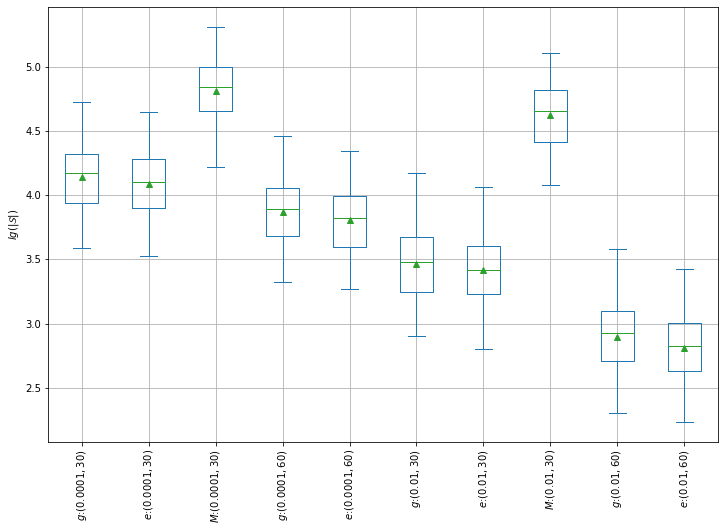

In [45]:
#plot(x=x, y=log_sizes, ylabel=r"$lg|\mathcal{S}|$",
#     labels=[r"$lg|\mathcal{S}_g|$", r"$lg|\mathcal{S}_e|$", r"$lg|\mathcal{S}_{M}|$", r"$lg|\mathcal{S}_{M^\prime}|$"],
#     xticks=params_list, title=r"log of the partition sizes $lg|\mathcal{S}|$", miny=2.75, maxy=5.25)
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:"],
       ex_cols=["|S_M|", "|S_P|", "|S_M_k|"], use_log=True, print_latex=True, ylabel=r"$lg(|\mathcal{S}|)$")
if save_images:
    plt.savefig("log_sizes.png", bbox_inches="tight")

In [46]:
#plot(x=x, y=sizes[:, :2], ylabel=r"$|\mathcal{S}|$", labels=[r"$|\mathcal{S}_g|$", r"$|\mathcal{S}_e|$"],
#     xticks=params_list, title=r"$|\mathcal{S}|$")

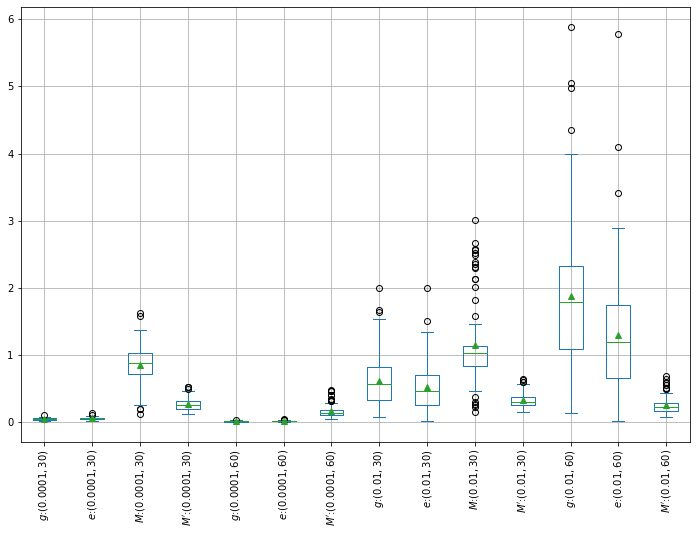

In [47]:
#plot(x=x, y=s2s, ylabel=r"$s2$",
#     labels=[r"$s2_g$", r"$s2_e$", r"$s2_{M}$", r"$s2_{M^\prime}$"],
#     xticks=params_list, title="Saturation in main iteration 2")
#plot(x=x, y=log_sizes, ylabel=r"$lg|\mathcal{S}|$",
#     labels=[r"$lg|\mathcal{S}_g|$", r"$lg|\mathcal{S}_e|$", r"$lg|\mathcal{S}_{M}|$", r"$lg|\mathcal{S}_{M^\prime}|$"],
#     xticks=params_list, title=r"log of the partition sizes $lg|\mathcal{S}|$", miny=2.75, maxy=5.25)
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["s2_M", "s2_P", "s2_M_k", "s2_M_ks"])
if save_images:    
    plt.savefig("s2.png", bbox_inches="tight")

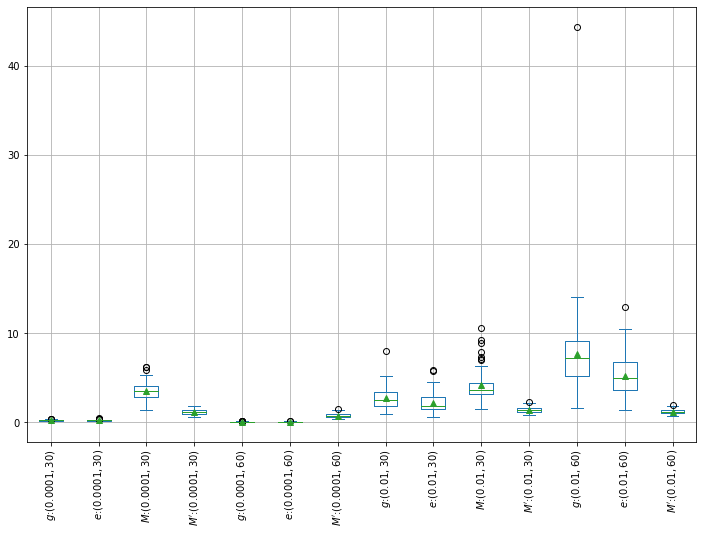

In [48]:
#plot(x=x, y=s3s, ylabel=r"$s3$",
#     labels=[r"$s3_g$", r"$s3_e$", r"$s3_{M}$", r"$s3_{M^\prime}$"],
#     xticks=params_list, title=r"Saturation in main iteration 3")
#plt.savefig("s3.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["s3_M", "s3_P", "s3_M_k", "s3_M_ks"])
if save_images:
    plt.savefig("s3.png", bbox_inches="tight")

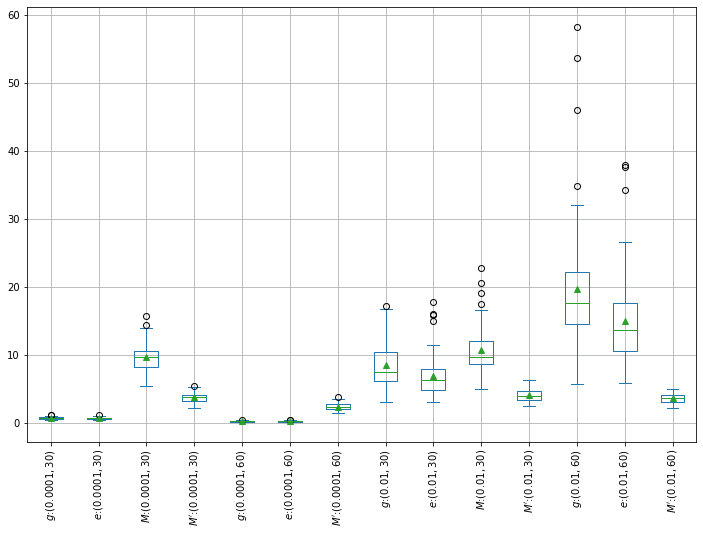

In [49]:
#plot(x=x, y=s4s, ylabel=r"$s4$",
#     labels=[r"$s4_g$", r"$s4_e$", r"$s4_{M}$", r"$s4_{M^\prime}$"],
#     xticks=params_list, title=r"Saturation in main iteration 4")
#plt.savefig("s4.png", bbox_inches="tight")

plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["s4_M", "s4_P", "s4_M_k", "s4_M_ks"])
if save_images:
    plt.savefig("s4.png", bbox_inches="tight")

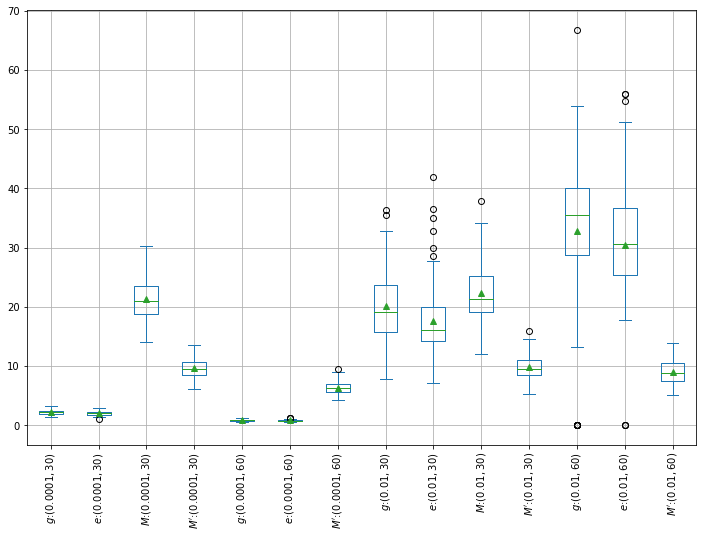

In [50]:
#lot(x=x, y=s5s, ylabel=r"$s5$",
#     labels=[r"$s5_g$", r"$s5_e$", r"$s5_{M}$", r"$s5_{M^\prime}$"],
#     xticks=params_list, title=r"Saturation in main iteration 5")
#plt.savefig("s5.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["s5_M", "s5_P", "s5_M_k", "s5_M_ks"])
if save_images:
    plt.savefig("s5.png", bbox_inches="tight")

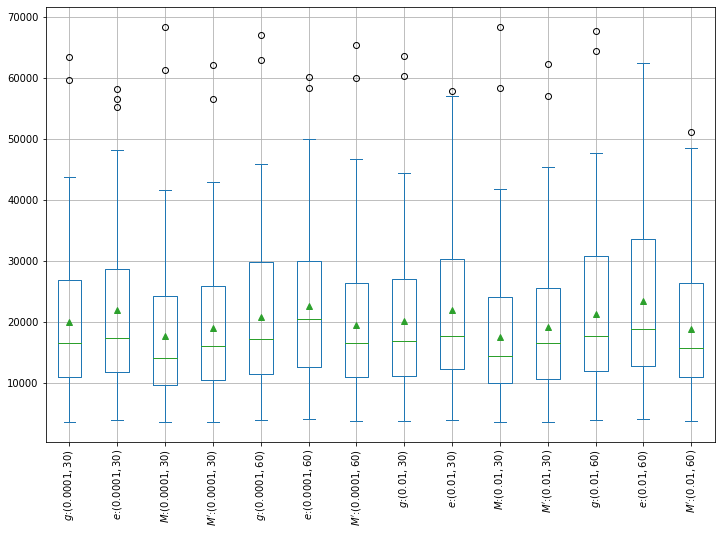

In [51]:
#plot(x=x, y=e1_1s, ylabel=r"$e11$",
#     labels=[r"$e11_g$", r"$e11_e$", r"$e11_{M}$", r"$e11_{M^\prime}$"],
#     xticks=params_list, title=r"Error 1 in main iteration 1")
#plt.savefig("e11.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e1_1_M", "e1_1_P", "e1_1_M_k", "e1_1_M_ks"])
if save_images:
    plt.savefig("e11.png", bbox_inches="tight")

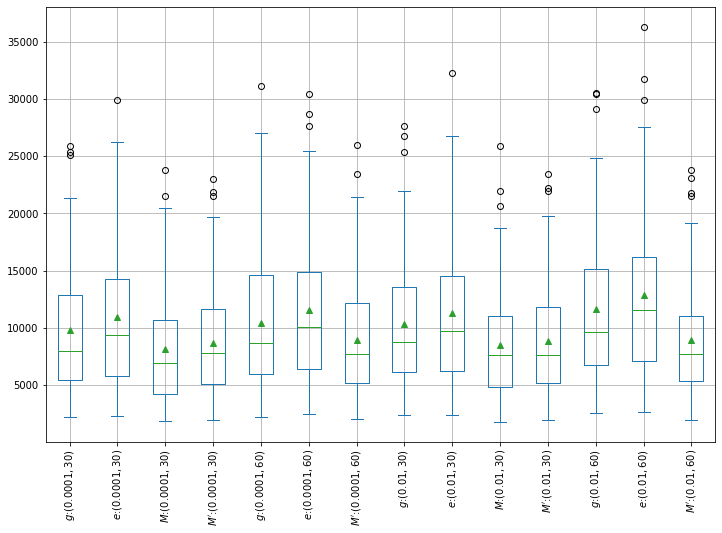

In [52]:
#plot(x=x, y=e1_2s, ylabel=r"$e12$",
#     labels=[r"$e12_g$", r"$e12_e$", r"$e12_{M}$", r"$e12_{M^\prime}$"],
#     xticks=params_list, title=r"Error 1 in main iteration 2")
#plt.savefig("e12.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e1_2_M", "e1_2_P", "e1_2_M_k", "e1_2_M_ks"])
if save_images:
    plt.savefig("e12.png", bbox_inches="tight")

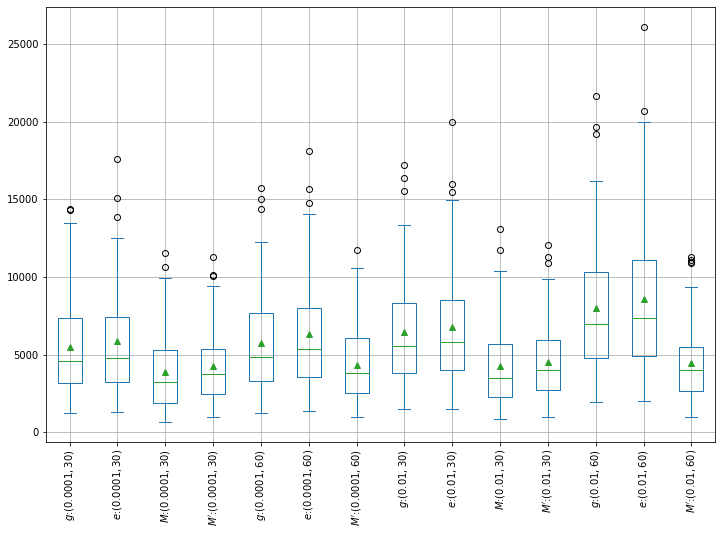

In [53]:
#plot(x=x, y=e1_3s, ylabel=r"$e13$",
#     labels=[r"$e13_g$", r"$e13_e$", r"$e13_{M}$", r"$e13_{M^\prime}$"],
#     xticks=params_list, title=r"Error 1 in main iteration 3")
#plt.savefig("e13.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e1_3_M", "e1_3_P", "e1_3_M_k", "e1_3_M_ks"])
if save_images:
    plt.savefig("e13.png", bbox_inches="tight")

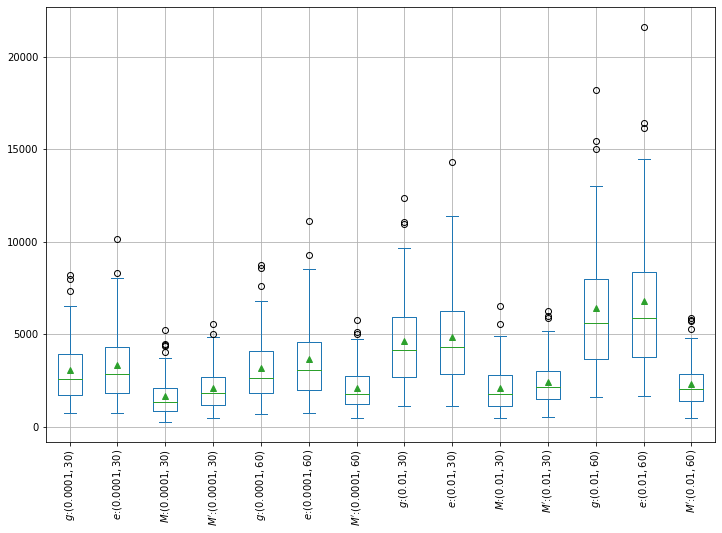

In [54]:
#plot(x=x, y=e1_4s, ylabel=r"$e14$",
#     labels=[r"$e14_g$", r"$e14_e$", r"$e14_{M}$", r"$e14_{M^\prime}$"],
#     xticks=params_list, title=r"Error 1 in main iteration 4")
#plt.savefig("e14.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e1_4_M", "e1_4_P", "e1_4_M_k", "e1_4_M_ks"])
if save_images:
    plt.savefig("e14.png", bbox_inches="tight")

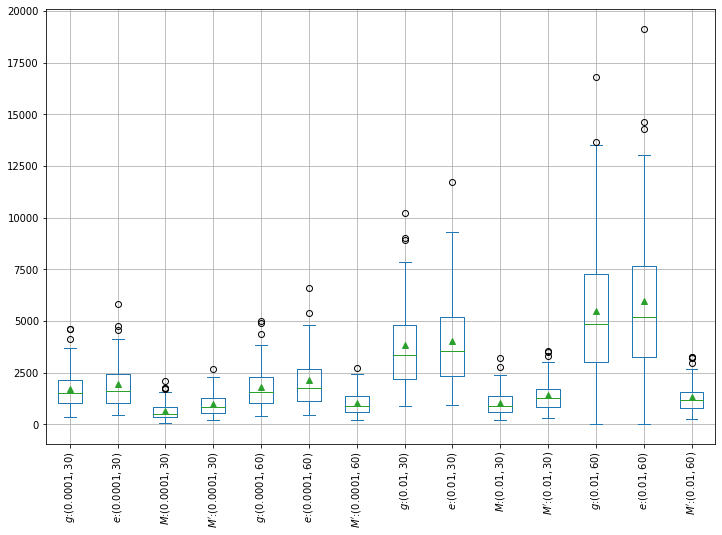

In [55]:
#plot(x=x, y=e1_5s, ylabel=r"$e15$",
#     labels=[r"$e15_g$", r"$e15_e$", r"$e15_{M}$", r"$e15_{M^\prime}$"],
#     xticks=params_list, title=r"Error 1 in main iteration 5")
#plt.savefig("e15.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e1_5_M", "e1_5_P", "e1_5_M_k", "e1_5_M_ks"])
if save_images:
    plt.savefig("e15.png", bbox_inches="tight")

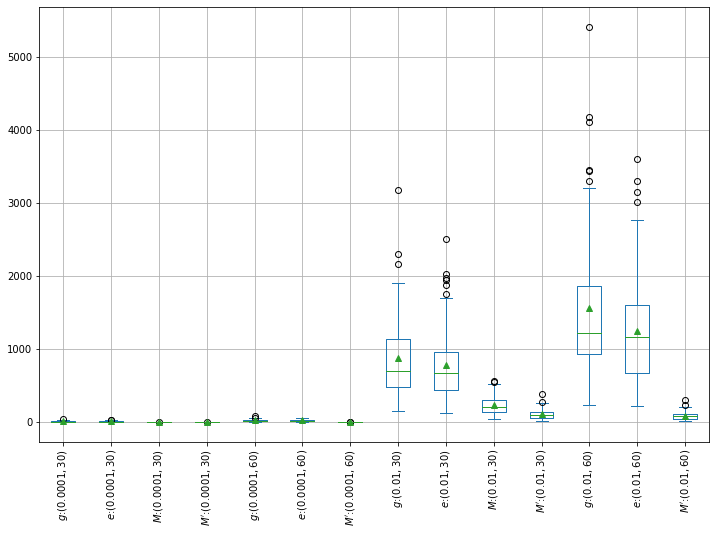

In [56]:
#plot(x=x, y=e2_1s, ylabel=r"$e21$",
#     labels=[r"$e21_g$", r"$e21_e$", r"$e21_{M}$", r"$e21_{M^\prime}$"],
#     xticks=params_list, title=r"Error 2 in main iteration 1")
#plt.savefig("e21.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e2_1_M", "e2_1_P", "e2_1_M_k", "e2_1_M_ks"])
if save_images:
    plt.savefig("e21.png", bbox_inches="tight")

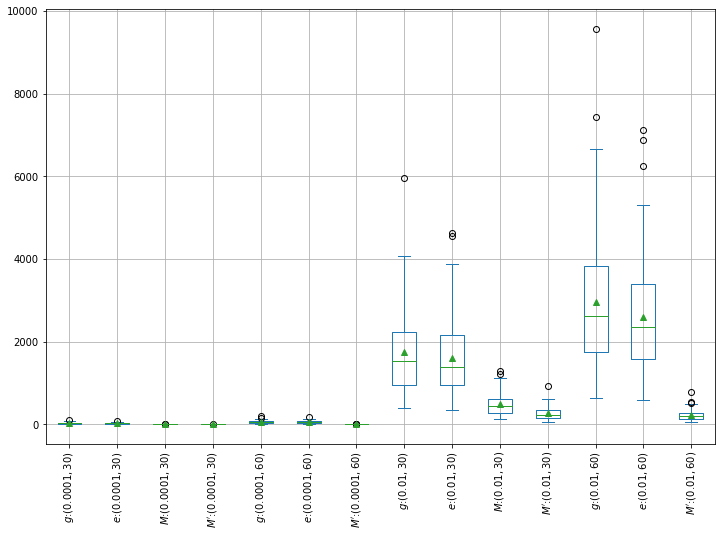

In [57]:
#plot(x=x, y=e2_2s, ylabel=r"$e22$",
#     labels=[r"$e22_g$", r"$e22_e$", r"$e22_{M}$", r"$e22_{M^\prime}$"],
#     xticks=params_list, title=r"Error 2 in main iteration 2")
#plt.savefig("e22.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e2_2_M", "e2_2_P", "e2_2_M_k", "e2_2_M_ks"])
if save_images:
    plt.savefig("e22.png", bbox_inches="tight")

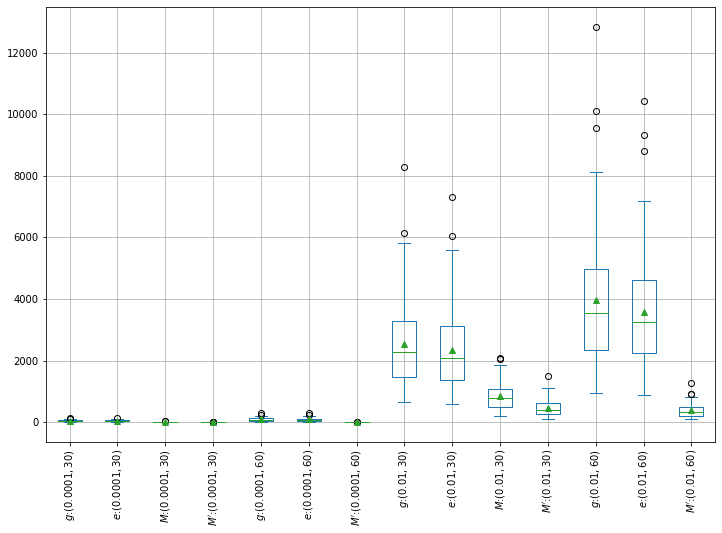

In [58]:
#plot(x=x, y=e2_3s, ylabel=r"$e23$",
#     labels=[r"$e23_g$", r"$e23_e$", r"$e23_{M}$", r"$e23_{M^\prime}$"],
#     xticks=params_list, title=r"Error 2 in main iteration 3")
#plt.savefig("e23.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e2_3_M", "e2_3_P", "e2_3_M_k", "e2_3_M_ks"])
if save_images:
    plt.savefig("e23.png", bbox_inches="tight")

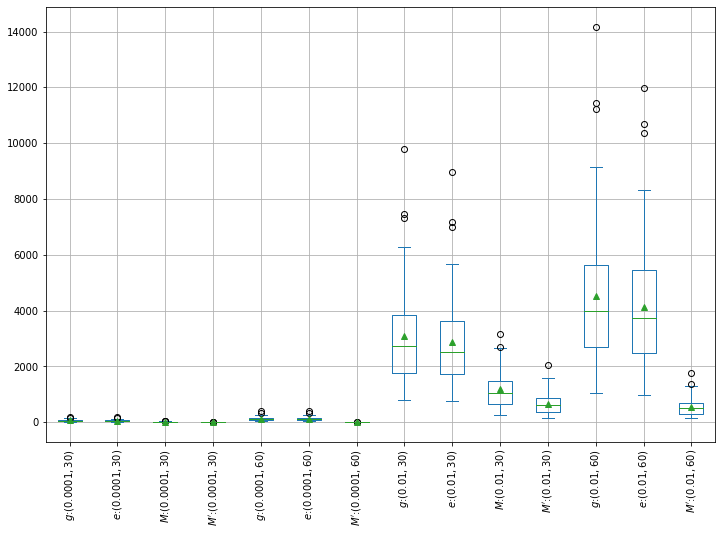

In [59]:
#plot(x=x, y=e2_4s, ylabel=r"$e24$",
#     labels=[r"$e24_g$", r"$e24_e$", r"$e24_{M}$", r"$e24_{M^\prime}$"],
#     xticks=params_list, title=r"Error 2 in main iteration 4")
#plt.savefig("e24.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e2_4_M", "e2_4_P", "e2_4_M_k", "e2_4_M_ks"])
if save_images:
    plt.savefig("e24.png", bbox_inches="tight")

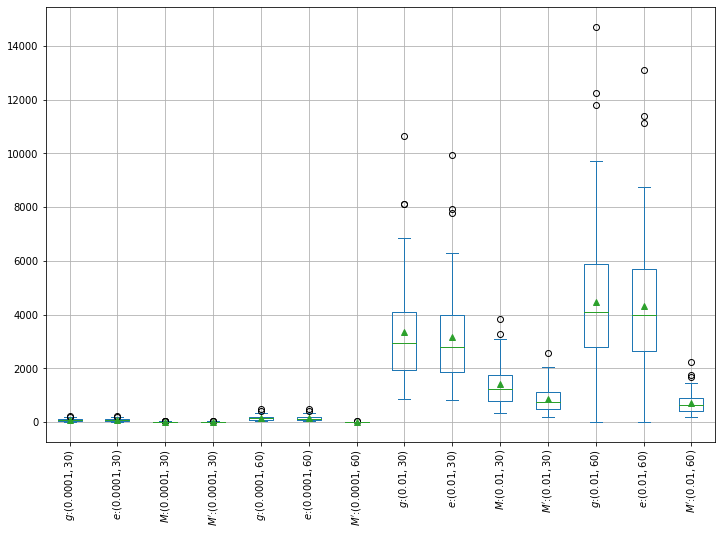

In [60]:
#plot(x=x, y=e2_5s, ylabel=r"$e25$",
#     labels=[r"$e25_g$", r"$e25_e$", r"$e25_{M}$", r"$e25_{M^\prime}$"],
#     xticks=params_list, title=r"Error 2 in main iteration 5")
#plt.savefig("e25.png", bbox_inches="tight")
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["e2_5_M", "e2_5_P", "e2_5_M_k", "e2_5_M_ks"])
if save_images:
    plt.savefig("e25.png", bbox_inches="tight")

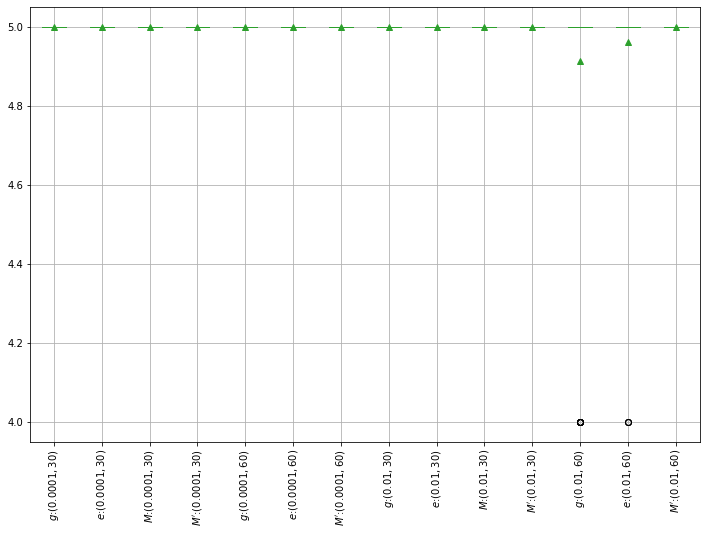

In [61]:
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["n_ite_M", "n_ite_P", "n_ite_M_k", "n_ite_M_ks"])
if save_images:
    plt.savefig("n_ite.png", bbox_inches="tight")

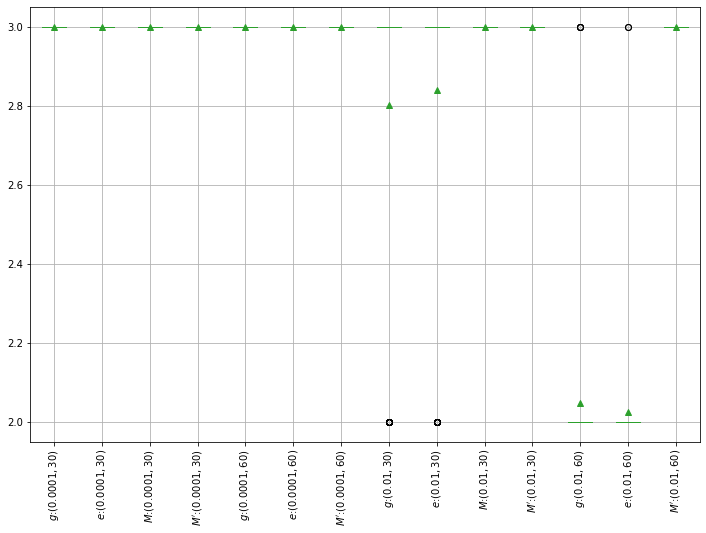

In [62]:
# 1: All components are saturated
# 2: Stopping criterion reached - Energieänderung < 0.05 (stopping_ratio)
# 3: Max number of iteration reached
plot_df(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
        col_names=[r"$g$:", r"$e$:", r"$M$:", r"$M^\prime$:"],
       ex_cols=["exit_code_M", "exit_code_P", "exit_code_M_k", "exit_code_M_ks"])
if save_images:
    plt.savefig("exit_code.png", bbox_inches="tight")

In [63]:
def to_df(stats_res, lmbda, k, n=3, pairs=None, test=None):
    data = []
    if type(stats_res) == pd.core.frame.DataFrame:
        #print(stats_res)
        for pair in pairs:
            p_val = stats_res.loc[[pair[0]], [pair[1]]]
            p_val = p_val.iloc[0, 0]
            print(p_val)
            row = [pair[0], pair[1], p_val, p_val < 0.05]
            data.append(row)
    else:
        data = []
        for a in stats_res.summary()[1:]:
            row = [str(a[0]), str(a[1]), float(str(a[3])), float(str(a[3])) < 0.05]
            data.append(row)
    df = pd.DataFrame(data)
    df.columns = [r"$g_1$", r"$g_2$", r"$p$", r"$p<0.5$"]
    if test is None:
        df.insert(0, r"$\lambda$", [lmbda for _ in range(n)])
        df.insert(1, r"$k$", [k for _ in range(n)])
    else:
        df.insert(0, "Var", [test for _ in range(n)])
        df.insert(1, r"$\lambda$", [lmbda for _ in range(n)])
        df.insert(2, r"$k$", [k for _ in range(n)])
        
    return df

def extract_df(i, stats_list, cp_args, ex_cols_, col_names_):
    df = stats_list[i][2].loc[:, ex_cols_].copy()
    col = []
    for c in col_names_:
        col.append(c + r"$({0}, {1})$".format(cp_args[i][0], cp_args[i][1]))
    df.columns = col
    return df, col

def hyp_test(cp_args, n_cp_args, stats_list, ex_cols, col_names, alpha=0.05, remove_outliers=True, test=None):
    df_all = None
    for i in range(n_cp_args):
        print("Test ({0}, {1})".format(cp_args[i][0], cp_args[i][1]))
        df, col = extract_df(i=i, stats_list=stats_list, cp_args=cp_args, ex_cols_=ex_cols, col_names_=col_names)

        arr_ = df.to_numpy()
        arr = np.array(arr_, copy=True)
        if remove_outliers:
            q025 = np.quantile(a=arr, q=0.25, axis=0)
            q075 = np.quantile(a=arr, q=0.75, axis=0)
            iqr = q075 - q025
            lb = q025 - 1.5 * iqr
            ub = q075 + 1.5 * iqr
            mask = (arr >= ub) | (arr <= lb)

            out_rows = np.sum(mask, axis=1)
            out_rows = np.where(out_rows > 0)[0]

            arr = np.delete(arr, out_rows, axis=0)
        is_normal = True
        for j in range(arr.shape[1]):
            _, p_val = st.shapiro(arr[:, j])
            is_normal = is_normal and p_val < alpha
        if is_normal:
            _, p_val = st.bartlett(arr[:, 0], arr[:, 1], arr[:, 2])
            equal_var = p_val < alpha
            if equal_var:
                print("Oneway ANOVA")
                _, p_val = st.f_oneway(arr[:, 0], arr[:, 1], arr[:, 2])
            else:
                raise Exception("Not Implemented")
            sig = p_val < alpha
            print("Significant: {0}".format(p_val < alpha))
            if sig:
                n = arr.shape[0]
                arr = np.concatenate(arr.transpose(), axis=0)
                g = []
                for c in col_names:
                    g.append(n*[c])
                g = np.concatenate(g)
                post_res = sp.posthoc_tukey_hsd(x=arr, g=g)
                print("Tukey HSD")
                res = pairwise_tukeyhsd(arr, g)
                df_res = to_df(stats_res=res, lmbda=cp_args[i][0], k=cp_args[i][1], test=test)
                #print(df_res)
                if df_all is None:
                    df_all = df_res
                else:
                    df_all = pd.concat([df_all, df_res], axis=0)
                #print(df_res.to_latex(escape=False))
        else:
            # apply non parametric test
            _, p_val = st.levene(arr[:, 0], arr[:, 1], arr[:, 2])
            equal_var = p_val < alpha
            if equal_var:
                print("Kruskal")
                _, p_val = st.kruskal(arr_[:, 0], arr_[:, 1], arr_[:, 2])
            else:
                _, p_val = st.alexandergovern(arr_[:, 0], arr_[:, 1], arr_[:, 2])
            sig = p_val < alpha
            print("Significant: {0}".format(p_val < alpha))
            if sig: 
                post_res = sp.posthoc_dunn(arr_.transpose(), p_adjust="holm")
                post_res.columns = col_names
                post_res.index = col_names
                print("Dunn")
                #print(post_res < alpha)
                #print(post_res)
                #df_res = pd.concat([post_res, post_res < alpha], axis=1)
                #df_res.insert(0, r"$\lambda$", [cp_args[i][0] for _ in range(3)])
                #df_res.insert(1, r"$k$", [cp_args[i][1] for _ in range(3)])
                #print(df_res.to_latex(escape=False))
                #print(type(post_res))
                df_res = to_df(stats_res=post_res, lmbda=cp_args[i][0], k=cp_args[i][1],
                      pairs=[
                          (col_names[-1], col_names[-2]),
                          (col_names[-1], col_names[-3]),
                          (col_names[-2], col_names[-3]),
                      ], test=test)
                #print(df_res)
                if df_all is None:
                    df_all = df_res
                else:
                    df_all = pd.concat([df_all, df_res], axis=0)
    print(df_all.to_latex(escape=False))

In [64]:
hyp_test(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
          ex_cols=["OOA_M", "OOA_P", "OOA_M_k"],
          col_names=[r"$g$:", r"$e$:", r"$M$:"], test="$OOA$")

Test (0.0001, 30)
Kruskal
Significant: True
Dunn
4.0640940939117146e-25
7.463307347924246e-20
0.20698051888989444
Test (0.0001, 60)
Kruskal
Significant: True
Dunn
1.0053877747164059e-27
5.104059218823972e-19
0.042834703867916435
Test (0.01, 30)
Kruskal
Significant: True
Dunn
8.724679523970455e-25
6.317024252578024e-19
0.15509984693487275
Test (0.01, 60)
Kruskal
Significant: True
Dunn
7.658664406241616e-27
1.0295522022348001e-19
0.0956082239548858
\begin{tabular}{llrrllrl}
\toprule
{} &    Var &  $\lambda$ &  $k$ & $g_1$ & $g_2$ &           $p$ &  $p<0.5$ \\
\midrule
0 &  $OOA$ &     0.0001 &   30 &  $M$: &  $e$: &  4.064094e-25 &     True \\
1 &  $OOA$ &     0.0001 &   30 &  $M$: &  $g$: &  7.463307e-20 &     True \\
2 &  $OOA$ &     0.0001 &   30 &  $e$: &  $g$: &  2.069805e-01 &    False \\
0 &  $OOA$ &     0.0001 &   60 &  $M$: &  $e$: &  1.005388e-27 &     True \\
1 &  $OOA$ &     0.0001 &   60 &  $M$: &  $g$: &  5.104059e-19 &     True \\
2 &  $OOA$ &     0.0001 &   60 &  $e$: &  

In [65]:
hyp_test(cp_args=cp_args, n_cp_args=n_cp_args, stats_list=stats_list, 
          ex_cols=["|S_M|", "|S_P|", "|S_M_k|"],
          col_names=[r"$g$:", r"$e$:", r"$M$:"], test=r"$|\mathcal{S}|$")

Test (0.0001, 30)
Oneway ANOVA
Significant: True
Tukey HSD
Test (0.0001, 60)
Oneway ANOVA
Significant: True
Tukey HSD
Test (0.01, 30)
Oneway ANOVA
Significant: True
Tukey HSD
Test (0.01, 60)
Oneway ANOVA
Significant: True
Tukey HSD
\begin{tabular}{llrrllrl}
\toprule
{} &              Var &  $\lambda$ &  $k$ & $g_1$ & $g_2$ &     $p$ &  $p<0.5$ \\
\midrule
0 &  $|\mathcal{S}|$ &     0.0001 &   30 &  $M$: &  $e$: &  0.0010 &     True \\
1 &  $|\mathcal{S}|$ &     0.0001 &   30 &  $M$: &  $g$: &  0.0010 &     True \\
2 &  $|\mathcal{S}|$ &     0.0001 &   30 &  $e$: &  $g$: &  0.8704 &    False \\
0 &  $|\mathcal{S}|$ &     0.0001 &   60 &  $M$: &  $e$: &  0.0010 &     True \\
1 &  $|\mathcal{S}|$ &     0.0001 &   60 &  $M$: &  $g$: &  0.0010 &     True \\
2 &  $|\mathcal{S}|$ &     0.0001 &   60 &  $e$: &  $g$: &  0.9000 &    False \\
0 &  $|\mathcal{S}|$ &     0.0100 &   30 &  $M$: &  $e$: &  0.0010 &     True \\
1 &  $|\mathcal{S}|$ &     0.0100 &   30 &  $M$: &  $g$: &  0.0010 &     Tr